In [1]:
import numpy as np
import einsum_benchmark
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

In [2]:
def get_tensor_info(instance):
    biggest_dim = 0
    biggest_number_of_dims = 0
    for tensor in instance.tensors:
        for dim in tensor.shape:
            if dim > biggest_dim:
                biggest_dim = dim
            if len(tensor.shape) > biggest_number_of_dims:
                biggest_number_of_dims = len(tensor.shape)
    return len(instance.tensors), biggest_dim, biggest_number_of_dims
        
def get_benchmarks(threshold: int = None):
    benchmark_data = {}
    idx = 0
    for instance in einsum_benchmark.instances:
        if threshold and len(instance.tensors) > threshold:
            continue
        benchmark_data[instance.name] = [idx, get_tensor_info(instance)]
        idx+=1
    return benchmark_data

In [129]:
#benchmark_data = get_benchmarks()
benchmark_data = get_benchmarks(1000)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar([i[0] for i in benchmark_data.values()], [i[1][0] for i in benchmark_data.values()])
axs[0].set_title("Number of tensors per benchmark")
axs[1].bar([i[0] for i in benchmark_data.values()], [i[1][1] for i in benchmark_data.values()])
axs[1].set_title("Size of the biggest dimension")
axs[2].bar([i[0] for i in benchmark_data.values()], [i[1][2] for i in benchmark_data.values()])
axs[2].set_title("Biggest tensor rank")

In [ ]:
#position, number of tensors, size of the biggest dimension, max number of dims
print(len(benchmark_data))

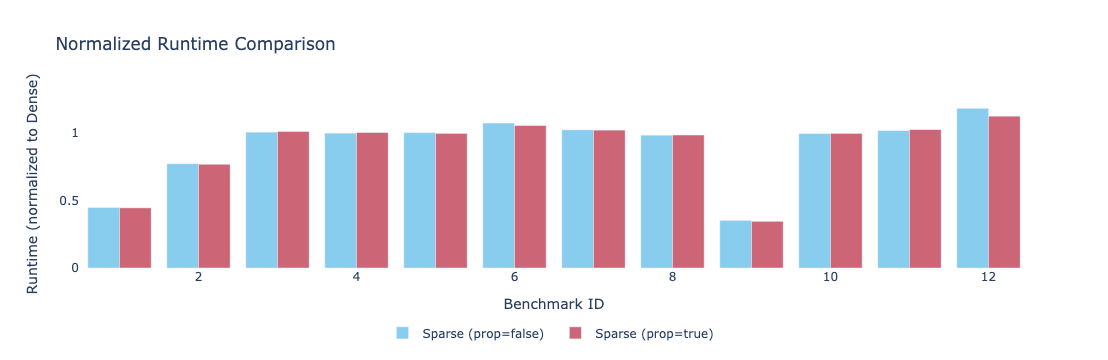

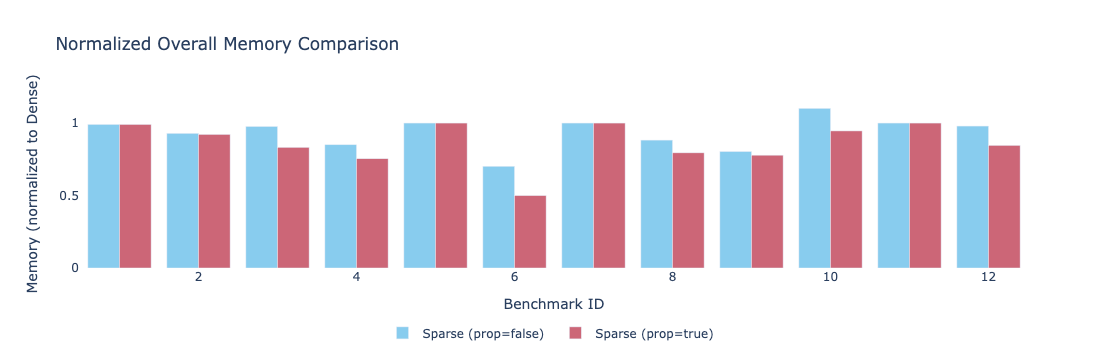

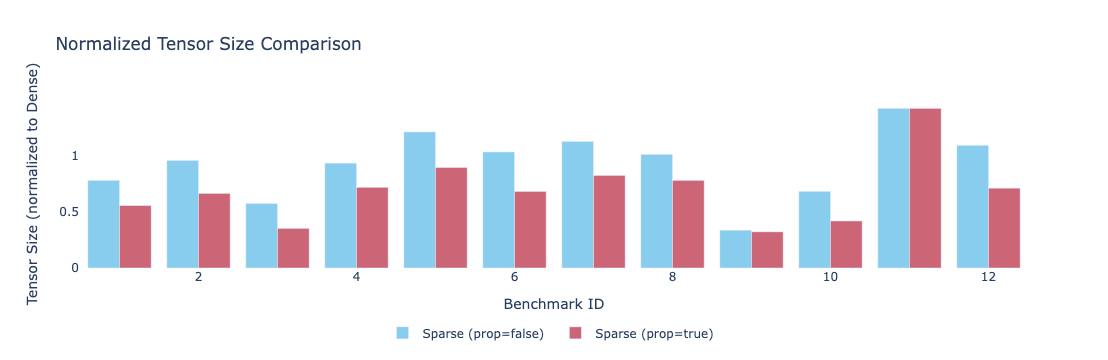

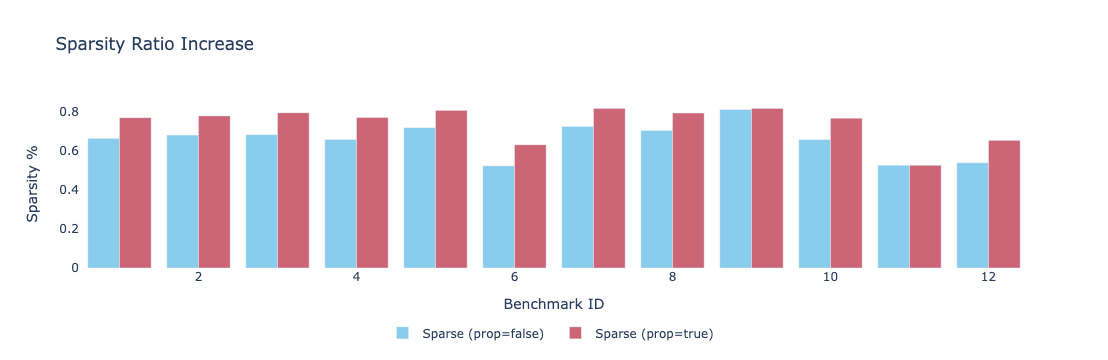

In [128]:
# --- Load and preprocess ---
df = pd.read_csv("einsum-data/13_50_5_complete.txt")
df.columns = df.columns.str.strip()
df = df.loc[df["file_name"] != "mc_2021_027.txt"]
df["benchmark_id"] = df["file_name"].factorize()[0] + 1

# Method labeling
def method_label(row):
    if row["format"] == "dense":
        return "Dense"
    elif row["format"] == "sparse" and row["propagate"] == 0:
        return "Sparse (prop=false)"
    elif row["format"] == "sparse" and row["propagate"] == 1:
        return "Sparse (prop=true)"
    else:
        return "Other"

df["method"] = df.apply(method_label, axis=1)
df = df.sort_values(by=['benchmark_id', 'format'])

# --- Normalization per benchmark ---
def normalize_metric(metric):
    dense_values = df.loc[df["method"] == "Dense", ["benchmark_id", metric]]
    dense_values = dense_values.rename(columns={metric: f"{metric}_dense"})

    merged = df.merge(dense_values, on="benchmark_id", how="left")
    merged[f"{metric}_norm"] = merged[metric] / merged[f"{metric}_dense"]
    return merged

df = normalize_metric("runtime")
df = normalize_metric("overall_memory")
df = normalize_metric("tensors-size")

# --- Filter out Dense bars ---
df_sparse = df[df["method"] != "Dense"]

# --- 1. Runtime comparison (normalized) ---
fig_runtime = px.bar(
    df_sparse,
    x="benchmark_id",
    y="runtime_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "runtime_norm": "Runtime (normalized to Dense)"},
    title="Normalized Runtime Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_runtime.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_runtime.show()

# --- 2. Memory comparison (normalized) ---
fig_memory = px.bar(
    df_sparse,
    x="benchmark_id",
    y="overall_memory_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "overall_memory_norm": "Memory (normalized to Dense)"},
    title="Normalized Overall Memory Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_memory.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_memory.show()

# --- 3. Tensor size comparison (normalized) ---
fig_tensors = px.bar(
    df_sparse,
    x="benchmark_id",
    y="tensors-size_norm",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "tensors-size_norm": "Tensor Size (normalized to Dense)"},
    title="Normalized Tensor Size Comparison",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_tensors.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_tensors.show()



fig_sparsity = px.bar(
    df_sparse,
    x="benchmark_id",
    y="ratio_after",
    color="method",
    barmode="group",
    labels={"benchmark_id": "Benchmark ID", "ratio_after": "Sparsity %"},
    title="Sparsity Ratio Increase",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig_sparsity.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3,
                                      xanchor="center", x=0.5), plot_bgcolor='white', legend_title=None)
fig_sparsity.show()

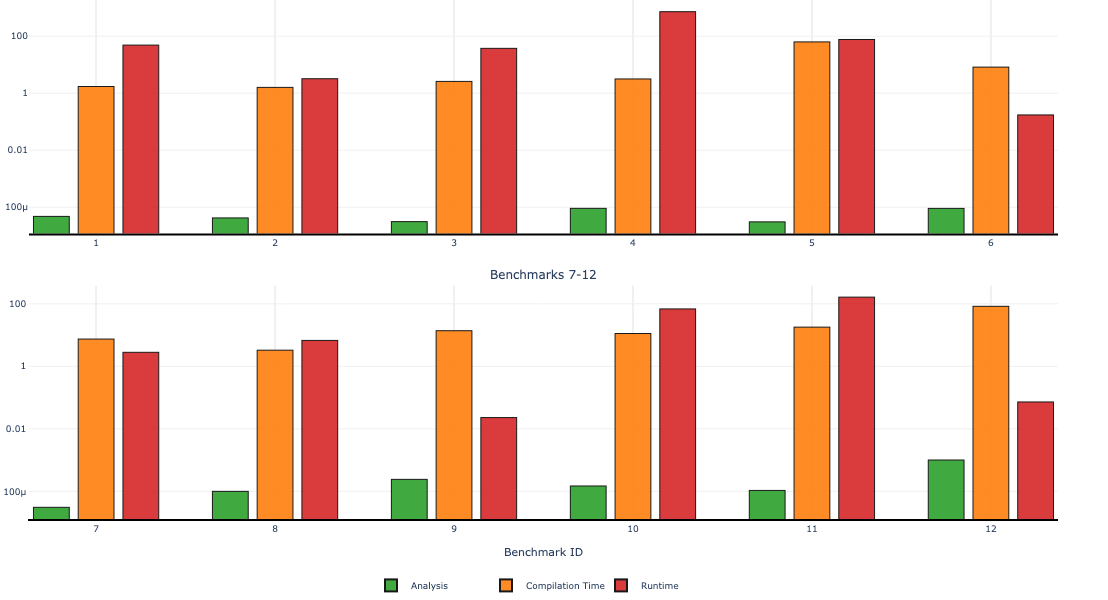

In [98]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Filter for sparse with propagation
df_sparse = df[df["method"] == "Sparse (prop=true)"]

# Melt the data
df_melt = df_sparse.melt(
    id_vars=["file_name", "method", "benchmark_id"],
    value_vars=["analysis", "compilation_time", "runtime"],
    var_name="metric",
    value_name="value"
)

# Create custom color mapping
color_map = {
    "analysis": "#2ca02c",  # Green for analysis
    "compilation_time": "#ff7f0e",  # Orange for compilation
    "runtime": "#d62728"  # Red for runtime
}

# Split benchmarks into two groups
all_benchmarks = sorted(df_melt["benchmark_id"].unique())
benchmarks_1 = all_benchmarks[:6]  # First 6 benchmarks
benchmarks_2 = all_benchmarks[6:]  # Remaining benchmarks

# Create subplots with 2 rows, 1 column
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Benchmarks 1-6', 'Benchmarks 7-12'),
    vertical_spacing=0.1,
    row_heights=[0.5, 0.5]
)

# Function to add bars to a subplot
def add_benchmark_subplot(fig, benchmarks, row):
    for metric in ["analysis", "compilation_time", "runtime"]:
        metric_data = df_melt[(df_melt["metric"] == metric) & 
                            (df_melt["benchmark_id"].isin(benchmarks))]
        
        # Calculate x positions for proper grouping
        x_positions = []
        benchmark_ticks = []
        current_x = 0
        
        for benchmark_id in benchmarks:
            x_positions.extend([current_x, current_x + 1, current_x + 2])
            benchmark_ticks.append(current_x + 1)  # Center of each group
            current_x += 4  # Space between benchmark groups
        
        # Get y values in correct order
        y_values = []
        for benchmark_id in benchmarks:
            benchmark_data = metric_data[metric_data["benchmark_id"] == benchmark_id]
            if not benchmark_data.empty:
                y_values.append(benchmark_data["value"].iloc[0])
            else:
                y_values.append(0)
        
        fig.add_trace(go.Bar(
            x=[i + (list(color_map.keys()).index(metric)) for i in range(0, len(benchmarks) * 4, 4)],
            y=y_values,
            name=metric.replace("_", " ").title(),
            marker_color=color_map[metric],
            marker_line_width=1,
            marker_line_color='black',
            opacity=0.9,
            width=0.8,
            showlegend=(row == 1),  # Only show legend for first row
            hovertemplate=(
                'Benchmark: %{customdata}<br>' +
                'Metric: ' + metric.replace("_", " ").title() + '<br>' +
                'Time: %{y:.3f}s<br>' +
                '<extra></extra>'
            ),
            customdata=benchmarks
        ), row=row, col=1)

# Add both subplots
add_benchmark_subplot(fig, benchmarks_1, 1)
add_benchmark_subplot(fig, benchmarks_2, 2)

# Apply professional styling
fig.update_layout(
    title=dict(
        #text="Analysis Time vs Compilation Time vs Runtime (propagation=true)",
        x=0.5,
        xanchor='center',
        font=dict(size=14, color='#2c3e50'),
        y=0.95
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.10,
        xanchor="center",
        x=0.5,
        font=dict(size=9),
        itemsizing='constant',
        entrywidth=70,
    ),
    margin=dict(t=0, b=0, l=0, r=50),  # Increased bottom margin for legend
    font=dict(size=9),
    hovermode='closest',
    width=500,  # Narrow width for single column
    height=600  # Increased height for two rows
)

# Customize x-axes
for row, benchmarks in enumerate([benchmarks_1, benchmarks_2], 1):
    fig.update_xaxes(
        tickvals=list(range(1, len(benchmarks) * 4, 4)),
        ticktext=[str(bid) for bid in benchmarks],
        row=row, col=1,
        showgrid=True,
        gridwidth=2,
        gridcolor='#f0f0f0',
        linecolor='black',
        linewidth=2,
        tickfont=dict(size=9),
        title_text="Benchmark ID" if row == 2 else ""
    )

# Customize y-axes with log scale
fig.update_yaxes(
    type='log',
    showgrid=True,
    gridwidth=1,
    gridcolor='#f0f0f0',
    #linecolor='black',
    #linewidth=1,
    tickfont=dict(size=9),
    #title_text="Time (s) - Log Scale",
    row=1, col=1
)

fig.update_yaxes(
    type='log',
    showgrid=True,
    gridwidth=1,
    gridcolor='#f0f0f0',
    #linecolor='black',
    linewidth=1,
    tickfont=dict(size=9),
    #title_text="Time (s) - Log Scale", 
    row=2, col=1
)

# Improve legend labels
fig.update_traces(
    name='Analysis',
    selector=dict(name='Analysis')
)
fig.update_traces(
    name='Compilation Time', 
    selector=dict(name='Compilation Time')
)
fig.update_traces(
    name='Runtime',
    selector=dict(name='Runtime')
)
fig.add_annotation(
        xref="paper",
        yref="paper",
        x=-0.1,
        y=0.5,
        text="Time (s) - Log Scale",
        showarrow=False,
        textangle=-90
)
fig.update_annotations(font_size=12)

fig.show()
pio.write_image(fig, "einsum_analysis_time.svg", width=500, height=600)


In [6]:
def read_csv(file_name):
    df = pd.read_csv(file_name)
    df = df.loc[df["file_name"] != "mc_2021_027.txt"]
    df.columns = df.columns.str.strip()
    df["benchmark_id"] = df["file_name"].factorize()[0] + 1
    df["method"] = df.apply(method_label, axis=1)
    df = df.sort_values(by=['benchmark_id', 'format'])
    return df

def filter_sparse(df):
    return df.loc[df['method'] == 'Sparse (prop=true)']

def filter_dense(df):
    #return df.loc[(df['method'] == 'Sparse (prop=false)') & (df['sparsity'] == 0.9)]
    return df.loc[df['method'] == 'Dense']

def get_avg(df):
    avg_cols = ["load_time", "compilation_time", "runtime", "overall_memory", "tensors-size"]

    df_avg = (
        df.groupby("file_name", as_index=False)
          .agg({
              "format": "first",
              "sparsity": "mean",
              "propagate": "first",
              "ratio_before": "mean",
              "ratio_after": "mean",
              "analysis": "mean",
              "load_time": "mean",
              "compilation_time": "mean",
              "runtime": "mean",
              "overall_memory": "mean",
              "tensors-size": "mean",
              "benchmark_id": "first",
              "method": "first"
          })
    )
    df_avg = df_avg.sort_values(by=['benchmark_id', 'format'])
    return df_avg

df_90 = read_csv("einsum-data/13_90_5_complete.txt")
df_70 = read_csv("einsum-data/13_70_5_complete.txt")
df_50 = read_csv("einsum-data/13_50_5_complete.txt")
df_30 = read_csv("einsum-data/13_30_5_complete.txt")

full_df = pd.concat([df_30, df_50, df_70, df_90])

full_sparse_df =  filter_sparse(full_df)
full_dense_df =  get_avg(filter_dense(full_df))

In [10]:
def plot_parametric(df):
    # First, let's extract the dense tensor sizes for normalization
    dense_sizes = {}
    for benchmark_id in df['benchmark_id'].unique():
        dense_df = df[(df['benchmark_id'] == benchmark_id) & (df['format'] == 'dense')]
        if not dense_df.empty:
            # Get the first dense entry (all should have same tensor size for same benchmark)
            dense_sizes[benchmark_id] = dense_df.iloc[0]['tensors-size']
    
    # Create a new column for normalized tensor size
    df['normalized_tensor_size'] = df.apply(
        lambda row: row['tensors-size'] / dense_sizes[row['benchmark_id']] 
        if row['benchmark_id'] in dense_sizes else np.nan, 
        axis=1
    )
    
    # Filter for sparse data only
    sparse_df = df[df['format'] == 'sparse'].copy()
    
    # Create a combined identifier for sparsity and propagation
    sparse_df['sparsity_prop'] = sparse_df['sparsity'].astype(str) + '_' + sparse_df['propagate'].astype(str)
    
    # Prepare data for plotting
    plot_data = []
    for benchmark_id in sorted(sparse_df['benchmark_id'].unique()):
        for sparsity in [0.9, 0.7, 0.5, 0.3]:
            # Get sparse without propagation (propagate=0)
            sparse_no_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 0)
            ]
            
            # Get sparse with propagation (propagate=1)
            sparse_with_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 1)
            ]
            
            if not sparse_no_prop.empty and not sparse_with_prop.empty:
                plot_data.append({
                    'benchmark_id': benchmark_id,
                    'sparsity': sparsity,
                    'sparse_no_prop_size': sparse_no_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_with_prop_size': sparse_with_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_no_prop_absolute': sparse_no_prop.iloc[0]['tensors-size'],
                    'sparse_with_prop_absolute': sparse_with_prop.iloc[0]['tensors-size'],
                    'dense_size': dense_sizes[benchmark_id]
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # layout = go.Layout(
    #     autosize=False,
    #     width=1000,
    #     height=350
    # )
    # fig = go.Figure(layout=layout)
    fig = go.Figure()
    
    # Colors for different sparsity levels
    sparsity_colors = {
        0.9: 'rgba(31, 119, 180, 0.8)',
        0.7: 'rgba(255, 127, 14, 0.8)',
        0.5: 'rgba(44, 160, 44, 0.8)',
        0.3: 'rgba(214, 39, 40, 0.8)'
    }
    
    sparsity_names = {
        0.9: '90% Sparsity',
        0.7: '70% Sparsity',
        0.5: '50% Sparsity',
        0.3: '30% Sparsity'
    }
    
    x_positions = []
    x_labels = []
    x_ticks = []
    benchmark_centers = []
    
    current_x = 0
    for benchmark_id in sorted(plot_df['benchmark_id'].unique()):
        benchmark_data = plot_df[plot_df['benchmark_id'] == benchmark_id]
        
        # Calculate the center position for this benchmark group
        benchmark_center = current_x + 1.5  # Center of the 4 bars (positions 0,1,2,3)
        benchmark_centers.append(benchmark_center)
        
        # Create positions for each sparsity level within this benchmark
        for sparsity in [0.9, 0.7, 0.5, 0.3]:
            sparsity_data = benchmark_data[benchmark_data['sparsity'] == sparsity]
            if not sparsity_data.empty:
                x_positions.append(current_x)
                current_x += 1
        
        # Add the benchmark ID label at the center position
        x_labels.append(str(benchmark_id))
        x_ticks.append(benchmark_center - 0.5)  # Adjust to show label between bars
        
        current_x += 1  # Add space between benchmarks
    # Add bars for sparse without propagation (outer bars)
    for sparsity in [0.9, 0.7, 0.5, 0.3]:
        sparsity_data = plot_df[plot_df['sparsity'] == sparsity]
        x_pos = [x_positions[i] for i, row in enumerate(plot_df.iterrows()) if row[1]['sparsity'] == sparsity]
        
        fig.add_trace(go.Bar(
            x=x_pos,
            y=sparsity_data['sparse_no_prop_size'],
            name=f'{sparsity_names[sparsity]} (No Prop)',
            marker_color=sparsity_colors[sparsity],
            marker_line_width=1.5,
            marker_line_color='darkgray',
            opacity=0.7,
            width=0.8,
            hovertemplate=(
                'Benchmark: %{customdata[0]}<br>' +
                'Sparsity: %{customdata[1]}%<br>' +
                'No Propagation: %{customdata[2]:.3f} (norm)<br>' +
                'With Propagation: %{customdata[3]:.3f} (norm)<br>' +
                'Absolute Sizes: %{customdata[4]:.3f} → %{customdata[5]:.3f}<br>' +
                'Dense Size: %{customdata[6]:.3f}<br>' +
                '<extra></extra>'
            ),
            customdata=np.column_stack((
                sparsity_data['benchmark_id'],
                sparsity_data['sparsity'] * 100,
                sparsity_data['sparse_no_prop_size'],
                sparsity_data['sparse_with_prop_size'],
                sparsity_data['sparse_no_prop_absolute'],
                sparsity_data['sparse_with_prop_absolute'],
                sparsity_data['dense_size']
            ))
        ))
    
    # Add bars for sparse with propagation (inner bars - placed on top)
    for sparsity in [0.9, 0.7, 0.5, 0.3]:
        sparsity_data = plot_df[plot_df['sparsity'] == sparsity]
        x_pos = [x_positions[i] for i, row in enumerate(plot_df.iterrows()) if row[1]['sparsity'] == sparsity]
        
        fig.add_trace(go.Bar(
            x=x_pos,
            y=sparsity_data['sparse_with_prop_size'],
            name=f'{sparsity_names[sparsity]} (With Prop)',
            marker_color=sparsity_colors[sparsity],
            marker_line_width=2,
            marker_line_color='black',
            opacity=0.9,
            width=0.6,
            hovertemplate=(
                'Benchmark: %{customdata[0]}<br>' +
                'Sparsity: %{customdata[1]}%<br>' +
                'With Propagation: %{y:.3f} (normalized)<br>' +
                'Absolute Size: %{customdata[2]:.3f}<br>' +
                'Reduction: %{customdata[3]:.1f}%<br>' +
                '<extra></extra>'
            ),
            customdata=np.column_stack((
                sparsity_data['benchmark_id'],
                sparsity_data['sparsity'] * 100,
                sparsity_data['sparse_with_prop_absolute'],
                (1 - sparsity_data['sparse_with_prop_size'] / sparsity_data['sparse_no_prop_size']) * 100
            ))
        ))
    
    # Update layout
    fig.update_layout(
        title='Normalized Tensor Size Comparison: Sparse vs Sparse+Propagation',
        xaxis_title='Benchmark ID',
        yaxis_title='Normalized Tensor Size (vs Dense)',
        barmode='overlay',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode='closest',
        plot_bgcolor='white'
    )
    
    # Customize x-axis
    fig.update_xaxes(
        tickvals=x_ticks,
        ticktext=x_labels,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
    
    # Customize y-axis
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black'
    )
    
    # Add a horizontal line at y=1 (dense baseline)
    fig.add_hline(y=1, line_dash="dash", line_color="red", 
                 annotation_text="Dense", 
                 annotation_position="right")
    
    fig.show()
    pio.write_image(fig, "einsum_parametric.svg", width=1100, height=370)

In [11]:
plot_parametric(full_df)

In [12]:
def plot_size(df):
    # Extract dense tensor sizes only
    dense_data = df[df['format'] == 'dense'].copy()
    dense_data = dense_data.drop_duplicates(subset=['benchmark_id', 'sparsity'])
    
    benchmark_sizes = []
    for benchmark_id in sorted(dense_data['benchmark_id'].unique()):
        benchmark_dense = dense_data[dense_data['benchmark_id'] == benchmark_id]
        if not benchmark_dense.empty:
            benchmark_sizes.append({
                'benchmark_id': benchmark_id,
                'tensor_size': benchmark_dense.iloc[0]['tensors-size'],
                'file_name': benchmark_dense.iloc[0]['file_name']
            })
    
    benchmark_df = pd.DataFrame(benchmark_sizes)
    
    # Create the plot
    fig_dense = go.Figure()
    
    # Use solid color with thick borders
    fig_dense.add_trace(go.Bar(
        x=benchmark_df['benchmark_id'],
        y=benchmark_df['tensor_size'],
        marker_color='rgba(214, 39, 40, 0.8)',      # SOLID color
        marker_line_width=1,         # THICK borders
        marker_line_color='black',   # White borders for contrast
        opacity=0.9,
        width=0.7,
        hovertemplate=(
            'Benchmark: %{x}<br>' +
            'Tensor Size: %{y:.3f}<br>' +
            'File: %{customdata}<br>' +
            '<extra></extra>'
        ),
        customdata=benchmark_df['file_name']
    ))
    
    # Apply professional styling
    def apply_professional_style(fig, title):
        fig.update_layout(
            plot_bgcolor='white',
            paper_bgcolor='white',
            font=dict(family='Arial', size=12, color='#333333'),
            title=dict(text=title, x=0.5, xanchor='center', 
                      font=dict(size=18, color='#2c3e50')),
            margin=dict(l=80, r=50, t=100, b=80),
            hoverlabel=dict(bgcolor='white', font_size=12, 
                           bordercolor='gray'),
            showlegend=False
        )
        
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=2,
            tickfont=dict(size=11),
            title_font=dict(size=13),
            title_text='Benchmark ID'
        )
        
        fig.update_yaxes(
            #showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            #linecolor='black',
            #linewidth=2,
            tickfont=dict(size=11),
            title_font=dict(size=13),
            title_text='Tensor Size in MB (Log Scale)',
            type='log'  # Keep the log scale
        )
        
        return fig
    
    # Apply styling
    fig_dense = apply_professional_style(fig_dense, 'Dense Tensor Sizes by Benchmark ID')
    
    # Add value labels on top of bars
    # fig_dense.update_traces(
    #     texttemplate='%{y:.1f}',
    #     textposition='outside',
    #     textfont=dict(size=10, color='#2c3e50')
    # )
    
    fig_dense.show()

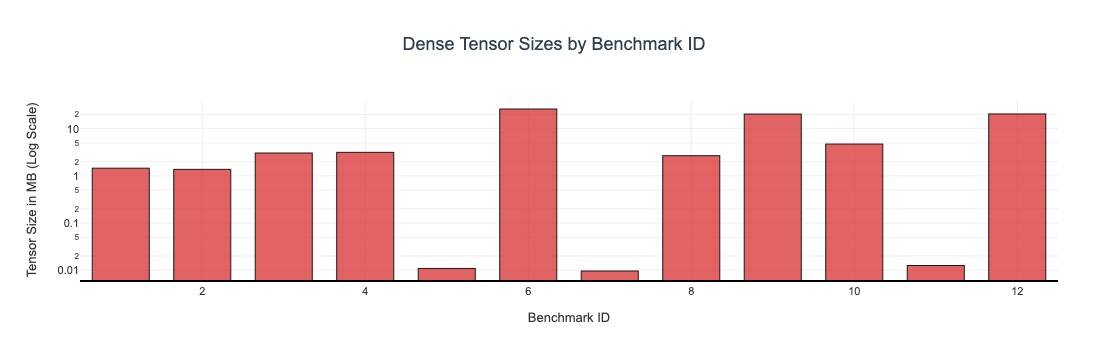

In [13]:
plot_size(full_df)

In [51]:
def plot_parametric_split(df):
    # First, let's extract the dense tensor sizes for normalization
    dense_sizes = {}
    for benchmark_id in df['benchmark_id'].unique():
        dense_df = df[(df['benchmark_id'] == benchmark_id) & (df['format'] == 'dense')]
        if not dense_df.empty:
            dense_sizes[benchmark_id] = dense_df.iloc[0]['tensors-size']
    
    # Create a new column for normalized tensor size
    df['normalized_tensor_size'] = df.apply(
        lambda row: row['tensors-size'] / dense_sizes[row['benchmark_id']] 
        if row['benchmark_id'] in dense_sizes else np.nan, 
        axis=1
    )
    
    # Filter for sparse data only
    sparse_df = df[df['format'] == 'sparse'].copy()
    
    # Prepare data for plotting
    plot_data = []
    for benchmark_id in sorted(sparse_df['benchmark_id'].unique()):
        for sparsity in [0.3, 0.5, 0.7, 0.9]:
            sparse_no_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 0)
            ]
            
            sparse_with_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 1)
            ]
            
            if not sparse_no_prop.empty and not sparse_with_prop.empty:
                plot_data.append({
                    'benchmark_id': benchmark_id,
                    'sparsity': sparsity,
                    'sparse_no_prop_size': sparse_no_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_with_prop_size': sparse_with_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_no_prop_absolute': sparse_no_prop.iloc[0]['tensors-size'],
                    'sparse_with_prop_absolute': sparse_with_prop.iloc[0]['tensors-size'],
                    'dense_size': dense_sizes[benchmark_id]
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Split benchmarks into two groups
    all_benchmarks = sorted(plot_df['benchmark_id'].unique())
    benchmarks_1 = all_benchmarks[:6]  # First 6 benchmarks
    benchmarks_2 = all_benchmarks[6:]  # Remaining benchmarks
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Benchmarks 1-6', 'Benchmarks 7-12'),
        vertical_spacing=0.1,
        row_heights=[0.5, 0.5]
    )
    fig.update_annotations(font_size=12) 
    
    # Colors and names
    sparsity_colors = {
        0.3: 'rgba(214, 39, 40, 0.8)',   # Red - 30%
        0.5: 'rgba(44, 160, 44, 0.8)',   # Green - 50% 
        0.7: 'rgba(255, 127, 14, 0.8)',  # Orange - 70%
        0.9: 'rgba(31, 119, 180, 0.8)'   # Blue - 90%
    }
    
    sparsity_names = {
        0.3: '30%',
        0.5: '50%',
        0.7: '70%', 
        0.9: '90%'
    }
    
    # Function to create plot for a subset of benchmarks
    def add_benchmark_subplot(fig, benchmarks, row):
        x_positions = []
        x_ticks = []
        benchmark_centers = []
        
        current_x = 0
        for benchmark_id in benchmarks:
            benchmark_data = plot_df[plot_df['benchmark_id'] == benchmark_id]
            
            benchmark_center = current_x + 1.5
            benchmark_centers.append(benchmark_center)
            
            for sparsity in [0.3, 0.5, 0.7, 0.9]:
                sparsity_data = benchmark_data[benchmark_data['sparsity'] == sparsity]
                if not sparsity_data.empty:
                    x_positions.append(current_x)
                    current_x += 1
            
            x_ticks.append(benchmark_center - 0.5)
            current_x += 1
        
        # Add bars for each sparsity level
        for sparsity in [0.3, 0.5, 0.7, 0.9]:
            sparsity_data = plot_df[(plot_df['sparsity'] == sparsity) & 
                                  (plot_df['benchmark_id'].isin(benchmarks))]
            x_pos = [x_positions[i] for i, row in enumerate(plot_df[plot_df['benchmark_id'].isin(benchmarks)].iterrows()) 
                    if row[1]['sparsity'] == sparsity]
            
            # Sparse without propagation
            fig.add_trace(go.Bar(
                x=x_pos,
                y=sparsity_data['sparse_no_prop_size'],
                name=f'{sparsity_names[sparsity]} (No Prop)' if row == 1 else '',
                marker_color=sparsity_colors[sparsity],
                marker_line_width=1.5,
                marker_line_color='darkgray',
                opacity=0.7,
                width=0.8,
                showlegend=(row == 1),
                hovertemplate=(
                    'Benchmark: %{customdata[0]}<br>' +
                    'Sparsity: %{customdata[1]}%<br>' +
                    'No Propagation: %{customdata[2]:.3f} (norm)<br>' +
                    '<extra></extra>'
                ),
                customdata=np.column_stack((
                    sparsity_data['benchmark_id'],
                    sparsity_data['sparsity'] * 100,
                    sparsity_data['sparse_no_prop_size']
                ))
            ), row=row, col=1)
            
            # Sparse with propagation
            fig.add_trace(go.Bar(
                x=x_pos,
                y=sparsity_data['sparse_with_prop_size'],
                name=f'{sparsity_names[sparsity]} (With Prop)' if row == 1 else '',
                marker_color=sparsity_colors[sparsity],
                marker_line_width=1,
                marker_line_color='black',
                opacity=0.9,
                width=0.6,
                showlegend=(row == 1),
                hovertemplate=(
                    'Benchmark: %{customdata[0]}<br>' +
                    'Sparsity: %{customdata[1]}%<br>' +
                    'With Propagation: %{y:.3f} (normalized)<br>' +
                    '<extra></extra>'
                ),
                customdata=np.column_stack((
                    sparsity_data['benchmark_id'],
                    sparsity_data['sparsity'] * 100
                ))
            ), row=row, col=1)
        
        # Update x-axis for this subplot
        fig.update_xaxes(
            tickvals=x_ticks,
            ticktext=[str(bid) for bid in benchmarks],
            row=row, col=1,
            title_text="Benchmark ID" if row == 2 else ""
        )
        
        # Add horizontal line for dense baseline
        fig.add_hline(y=1, line_dash="dash", line_color="red", 
                     row=row, col=1)
    
    # Add both subplots
    add_benchmark_subplot(fig, benchmarks_1, 1)
    add_benchmark_subplot(fig, benchmarks_2, 2)

    # Customize x-axis
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
    )

    # Customize y-axis
    fig.update_yaxes(
        #title_text="Normalized Tensor Size (vs Dense)",
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black',
        #side='left',
    )
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=-0.06,
        y=0.5,
        text="Normalized Tensor Size (vs Dense)",
        showarrow=False,
        textangle=-90
    )

    fig.update_layout(
        height=700,  # Reduced height since legend is below
        width=500,
        barmode='overlay',
        showlegend=True,
        # Compact legend configuration
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.10,  # Further down
            xanchor="center",
            x=0.5,
            font=dict(size=8),  # Very small but readable
            itemsizing="constant",
            entrywidth=60,  # Very compact entries
            traceorder="normal",
            valign="top",
        ),
        hovermode='closest',
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=0, b=0, l=0, r=50),
        font=dict(size=9)
    )
    
    fig.update_xaxes(
        title_font=dict(size=10),
        tickfont=dict(size=8)
    )
    fig.show()
    pio.write_image(fig, "einsum_parametric_split.svg", width=500, height=600)

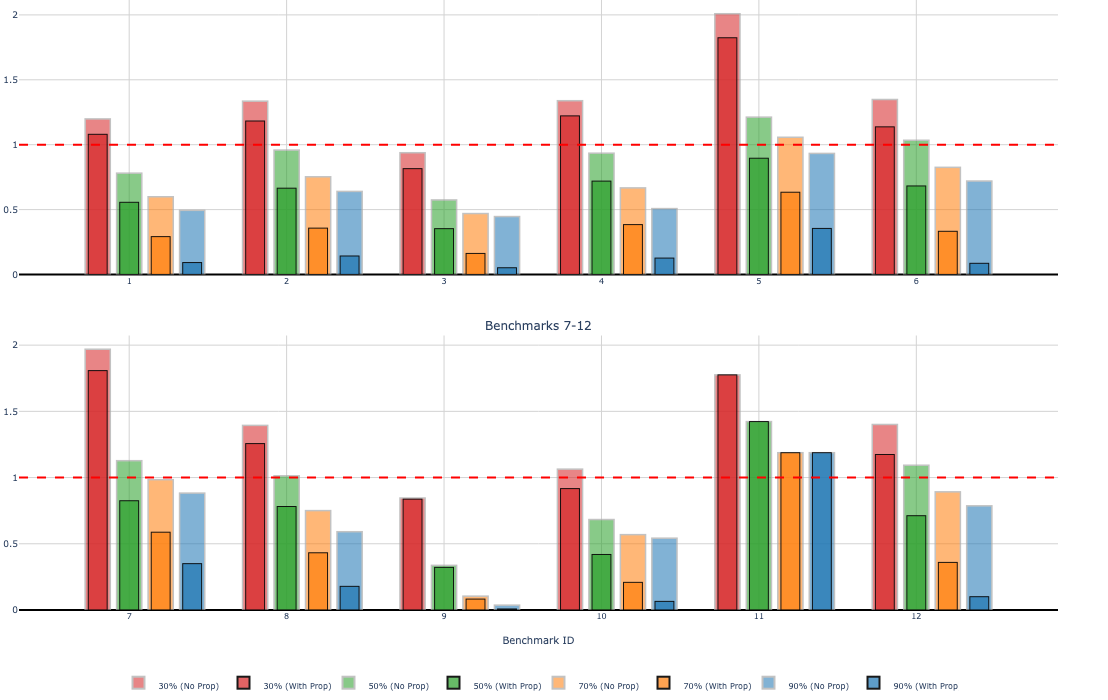

In [52]:
plot_parametric_split(full_df)